In [246]:
%reset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Read data, remap polygon numbers to range from 0 to 689 consistent with OAE Atlas conventions.

In [247]:
atlas_data = xr.open_dataset('oae_eff_curves_global.nc')

atlas_r1 = atlas_data.sel(region = 'Atlantic').isel(polygon=np.arange(0,150))
atlas_r2 = atlas_data.sel(region = 'Pacific').isel(polygon=np.arange(0,200))
atlas_r3 = atlas_data.sel(region = 'South').isel(polygon=np.arange(0,300))
atlas_r4 = atlas_data.sel(region = 'Southern_Ocean').isel(polygon=np.arange(0,40))

atlas_full = xr.concat([atlas_r1,atlas_r2,atlas_r3,atlas_r4],dim='polygon').drop_vars('region').drop_vars('polygon').assign_coords(polygon=(np.arange(690)))

In [248]:
print(atlas_full)

<xarray.Dataset>
Dimensions:         (polygon: 690, season: 4, time: 189)
Coordinates:
  * time            (time) object 0347-01-16 12:00:00 ... 0362-09-16 00:00:00
  * season          (season) object 'January' 'April' 'July' 'October'
  * polygon         (polygon) int64 0 1 2 3 4 5 6 ... 684 685 686 687 688 689
Data variables:
    time_delta      (season, time, polygon) float64 31.0 31.0 31.0 ... 30.0 30.0
    OAE_efficiency  (season, polygon, time) float64 0.01463 0.02522 ... 0.7729


### Select polygon index number, read OAE efficiency data for all seasons

In [250]:
i_polygon = 0; #index of polygon from OAE Atlas 

polygon_data = atlas_full.sel(polygon = i_polygon)

#Reading in OAE Global Atlas data:
IRF_01 = polygon_data.OAE_efficiency[0,:].dropna(dim='time').values
IRF_04 = polygon_data.OAE_efficiency[1,:].dropna(dim='time').values
IRF_07 = polygon_data.OAE_efficiency[2,:].dropna(dim='time').values
IRF_10 = polygon_data.OAE_efficiency[3,:].dropna(dim='time').values

#Linear interpolation to obtain IRF for each month:
IRF_02 = (2/3)*IRF_01+(1/3)*IRF_04
IRF_03 = (1/3)*IRF_01+(2/3)*IRF_04

IRF_05 = (2/3)*IRF_04+(1/3)*IRF_07
IRF_06 = (1/3)*IRF_04+(2/3)*IRF_07

IRF_08 = (2/3)*IRF_07+(1/3)*IRF_10
IRF_09 = (1/3)*IRF_07+(2/3)*IRF_10

IRF_11 = (2/3)*IRF_10+(1/3)*IRF_01
IRF_12 = (1/3)*IRF_10+(2/3)*IRF_01


#Assign same IRFs for each month through a 5 year period
for i in range(1,5):
    globals()[f'IRF_{i*12+1:02d}']=IRF_01
    globals()[f'IRF_{i*12+2:02d}']=IRF_02
    globals()[f'IRF_{i*12+3:02d}']=IRF_03
    globals()[f'IRF_{i*12+4:02d}']=IRF_04
    globals()[f'IRF_{i*12+5:02d}']=IRF_05
    globals()[f'IRF_{i*12+6:02d}']=IRF_06
    globals()[f'IRF_{i*12+7:02d}']=IRF_07
    globals()[f'IRF_{i*12+8:02d}']=IRF_08
    globals()[f'IRF_{i*12+9:02d}']=IRF_09
    globals()[f'IRF_{i*12+10:02d}']=IRF_10
    globals()[f'IRF_{i*12+11:02d}']=IRF_11
    globals()[f'IRF_{i*12+12:02d}']=IRF_12

    #print(f'IRF_{i*12+12:02d}')

In [251]:
polygon_data.OAE_efficiency.shape

(4, 189)

Text(0.5, 1.0, ' Polygon 0')

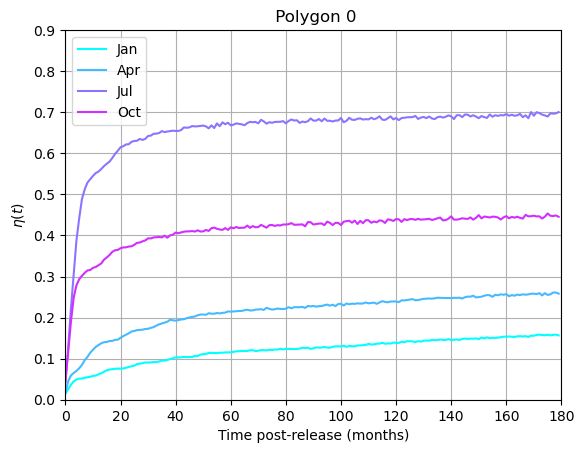

In [252]:
#plt.figure(figsize=(5,3),dpi=150)
colors = (plt.cm.cool(np.linspace(0, 1, 12)))

plt.plot(IRF_01,label='Jan',color=colors[0])
plt.plot(IRF_04,label='Apr',color=colors[3])
plt.plot(IRF_07,label='Jul',color=colors[6])
plt.plot(IRF_10,label='Oct',color=colors[9])
plt.legend()
plt.grid(); plt.xlim([0,180]); plt.ylim([0,0.9]); plt.xlabel('Time post-release (months)'); plt.ylabel('$\eta(t)$'); 

plt.title(' Polygon %i'%(i_polygon))

Text(0.5, 1.0, 'Monthly IRFs for Polygon 0')

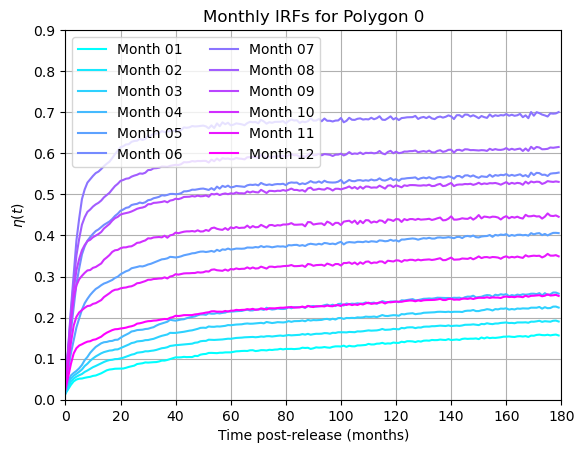

In [253]:
#plt.figure(figsize=(5,3),dpi=550)
colors = (plt.cm.cool(np.linspace(0, 1, 12)))

for i in range(1,13):
    #print(i)
    plt.plot(globals()[f'IRF_{i:02d}'],label=f'Month {i:02d}',c=colors[i-1])

plt.legend(ncol=2)
plt.grid(); plt.xlim([0,180]); plt.ylim([0,0.9]); plt.xlabel('Time post-release (months)'); plt.ylabel('$\eta(t)$'); 

plt.title('Monthly IRFs for Polygon %i'%(i_polygon))

## Specify forcing, max duration is 5 years; we'll generate prediction for 10 years post-release. All forcings have an average of 1 mol/m^2/month.

Text(0.5, 0.98, 'Alkalinity Forcing Timeseries')

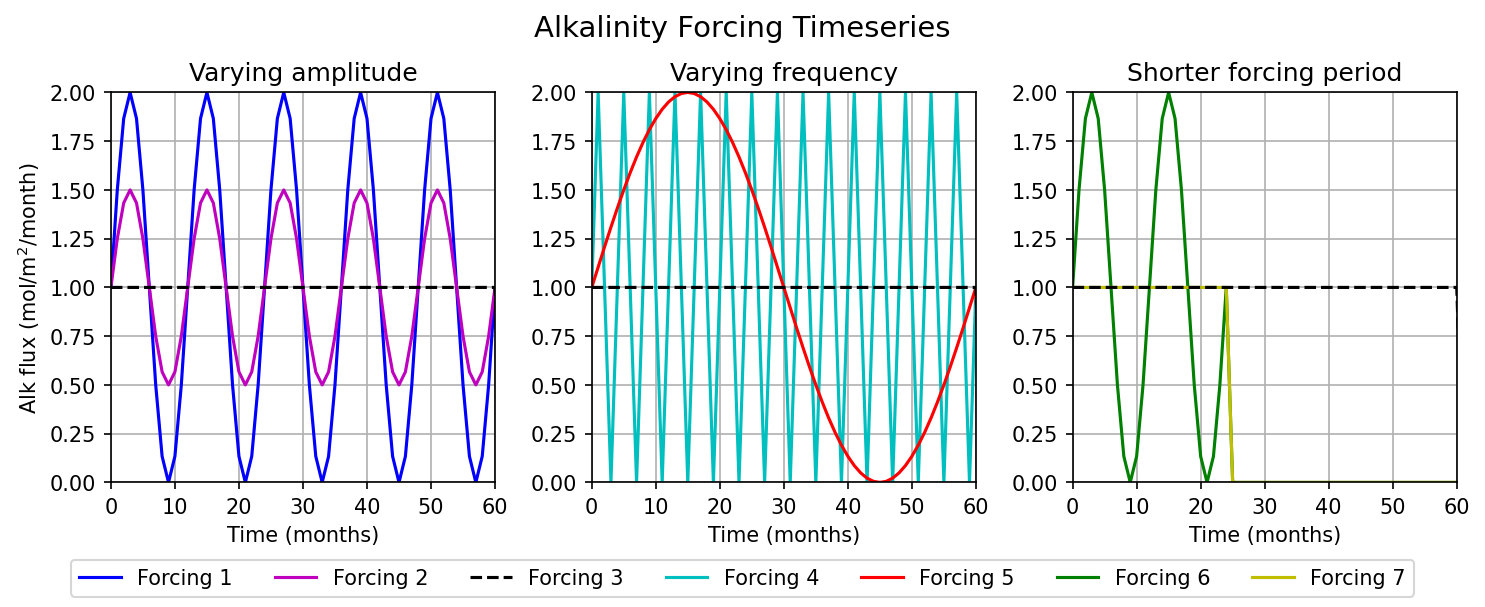

In [254]:
fig=plt.figure(figsize=(10,4),dpi=150)

ftime = np.linspace(0,179,180)# generate time series for 15 years, 180 months

option_1 = np.sin(5*ftime*2*np.pi/(60))+1;     option_1[61:]=0.;
option_2 = np.sin(5*ftime*2*np.pi/(60))*0.5+1; option_2[61:]=0.;
option_3 = ftime*0+1; option_3[61:]=0.;        option_3[61:]=0.;

option_4 = np.sin(15*ftime*2*np.pi/(60))+1;    option_4[61:]=0.;
option_5 = np.sin(1*ftime*2*np.pi/(60))+1;     option_5[61:]=0.;

option_6 = np.sin(5*ftime*2*np.pi/(60))+1; option_6[25:]=0
option_7 = ftime*0+1; option_7[25:]=0


yhi = 2; xhi = 60
ax1=plt.subplot(1,3,1)
plt.plot(ftime,option_1,'b',label='Forcing 1')
plt.plot(ftime,option_2,'m',label='Forcing 2')
plt.plot(ftime,option_3,'--k',label='Forcing 3')
plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); plt.ylabel('Alk flux (mol/m$^2$/month)')
plt.title('Varying amplitude')

ax2=plt.subplot(1,3,2)
plt.plot(ftime,option_4,'c',label='Forcing 4')
plt.plot(ftime,option_5,'r',label='Forcing 5')
plt.plot(ftime,option_3,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.title('Varying frequency')

ax3=plt.subplot(1,3,3)
plt.plot(ftime,option_6,'g',label='Forcing 6')
plt.plot(ftime,option_7,'y',label='Forcing 7')
plt.plot(ftime,option_3,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.tight_layout()
plt.title('Shorter forcing period')

fig.legend(loc="lower center",ncol=7) 
plt.tight_layout()
plt.subplots_adjust(bottom=0.2,top=0.85)
plt.suptitle('Alkalinity Forcing Timeseries',fontsize=14)

#plt.savefig('fig1.png')

## We now perform a month-by-month convolution, sum, and normalize to get uptake curve:


In [255]:
convolution_1   = np.zeros(option_1.shape);
convolution_2   = np.zeros(option_2.shape);
convolution_3   = np.zeros(option_3.shape);
convolution_4   = np.zeros(option_4.shape);
convolution_5   = np.zeros(option_5.shape);
convolution_6   = np.zeros(option_6.shape);
convolution_7   = np.zeros(option_7.shape);

for i in range(0,60):
    convolution_local = np.convolve(option_1, globals()[f'IRF_{i+1:02d}'])
    convolution_1[i:180] = convolution_1[i:180] + convolution_local[0:180-i]

    convolution_local = np.convolve(option_2, globals()[f'IRF_{i+1:02d}'])
    convolution_2[i:180] = convolution_2[i:180] + convolution_local[0:180-i]

    convolution_local = np.convolve(option_3, globals()[f'IRF_{i+1:02d}'])
    convolution_3[i:180] = convolution_3[i:180] + convolution_local[0:180-i]

    convolution_local = np.convolve(option_4, globals()[f'IRF_{i+1:02d}'])
    convolution_4[i:180] = convolution_4[i:180] + convolution_local[0:180-i]

    convolution_local = np.convolve(option_5, globals()[f'IRF_{i+1:02d}'])
    convolution_5[i:180] = convolution_5[i:180] + convolution_local[0:180-i]

    convolution_local = np.convolve(option_6, globals()[f'IRF_{i+1:02d}'])
    convolution_6[i:180] = convolution_6[i:180] + convolution_local[0:180-i]

    convolution_local = np.convolve(option_7, globals()[f'IRF_{i+1:02d}'])
    convolution_7[i:180] = convolution_7[i:180] + convolution_local[0:180-i]


Text(0.5, 0.98, 'Convolution Results')

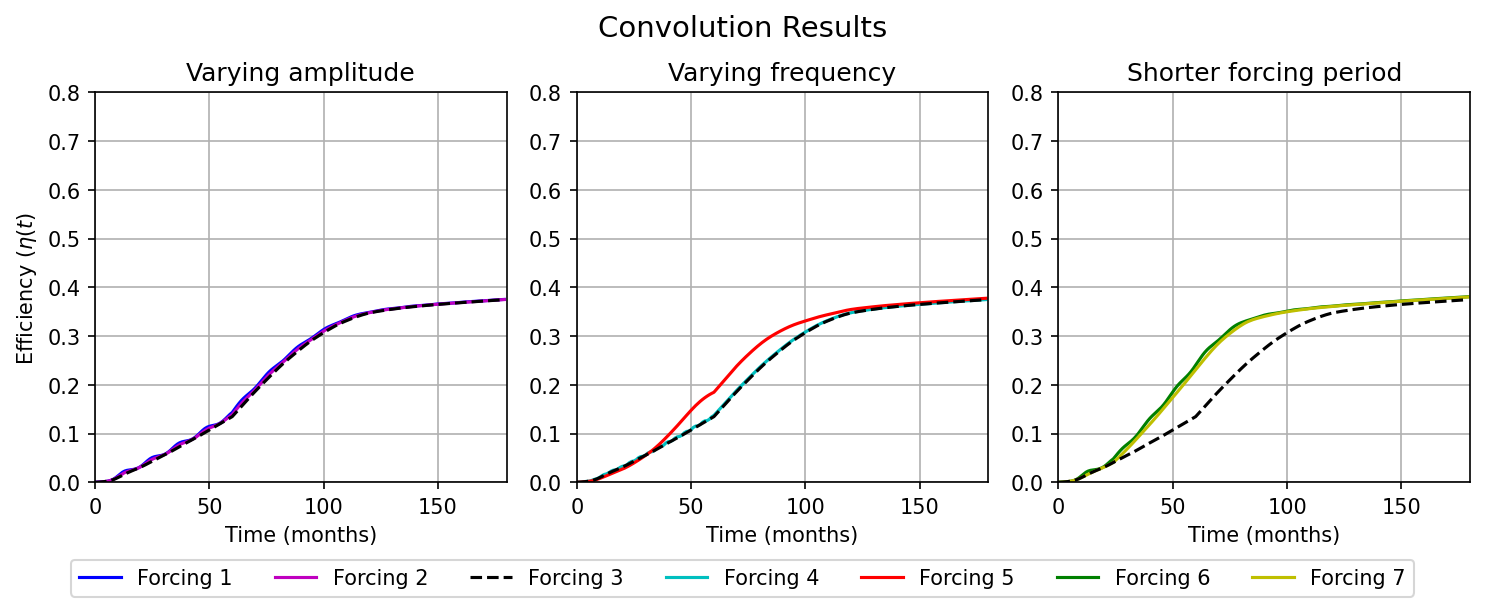

In [256]:
fig=plt.figure(figsize=(10,4),dpi=150)

yhi = .8; xhi = 180
plt.subplot(1,3,1)
plt.plot(ftime,convolution_1/np.cumsum(option_1)/60,'b',label= 'Forcing 1') #normalize by length of time in months forcing is applied
plt.plot(ftime,convolution_2/np.cumsum(option_2)/60,'m', label= 'Forcing 2')
plt.plot(ftime,convolution_3/np.cumsum(option_3)/60,'--k', label= 'Forcing 3')
plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); plt.ylabel('Efficiency ($\eta(t)$')
plt.title('Varying amplitude')

plt.subplot(1,3,2)
plt.plot(ftime,convolution_4/np.cumsum(option_4)/60,'c', label= 'Forcing 4')
plt.plot(ftime,convolution_5/np.cumsum(option_5)/60,'r', label= 'Forcing 5')
plt.plot(ftime,convolution_3/np.cumsum(option_3)/60,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.title('Varying frequency')

plt.subplot(1,3,3)
plt.plot(ftime,convolution_6/np.cumsum(option_6)/60,'g',label= 'Forcing 6')
plt.plot(ftime,convolution_7/np.cumsum(option_7)/60,'y', label= 'Forcing 7')
plt.plot(ftime,convolution_3/np.cumsum(option_3)/60,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.title('Shorter forcing period')

fig.legend(loc="lower center",ncol=7) 
plt.tight_layout()
plt.subplots_adjust(bottom=0.2,top=0.85)
plt.suptitle('Convolution Results',fontsize=14)
#plt.savefig('fig2.png')